# Part 2 & 3 — Full experiments (6 experiments) + metrics + plots
This notebook runs all required experiments and produces:
- Elbow + silhouette + gap (KMeans)
- BIC/AIC (GMM)
- PCA & AE sweeps (dims: 2,5,10,15,20)
- Internal & external metrics
- Comparison tables

>You can reduce epochs for faster iteration.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
os.chdir("..")
sys.path.append(os.getcwd())

from src.utils.random import set_seed
from src.utils.preprocessing import StandardScaler


In [7]:
import os
os.chdir('..')
import sys
sys.path.append('.')


In [8]:
from src.experiments.model_selection import elbow_inertia, silhouette_over_k, gap_statistic
from src.experiments.pipeline import (
    compute_all_metrics, run_kmeans, run_gmm, pca_embed, ae_embed
)
from src.visualization.plots import line_curve, scatter_2d


In [9]:
# Data loading (Breast Cancer Wisconsin Diagnostic)
# We avoid sklearn for loading; we use pandas to read the UCI dataset.
# If you're offline, download the CSV once and set LOCAL_CSV path.

UCI_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
LOCAL_CSV = None  # e.g. "data/wdbc.data"

cols = ["id", "diagnosis"] + [f"f{i}" for i in range(30)]
if LOCAL_CSV is None:
    df = pd.read_csv(UCI_URL, header=None, names=cols)
else:
    df = pd.read_csv(LOCAL_CSV, header=None, names=cols)

y = (df["diagnosis"].values == "M").astype(int)  # Malignant=1, Benign=0 (used ONLY for evaluation)
X = df.drop(columns=["id","diagnosis"]).values.astype(float)

scaler = StandardScaler()
Xs = scaler.fit_transform(X)

print("X:", X.shape, "Xs:", Xs.shape, "Malignant%:", y.mean())


X: (569, 30) Xs: (569, 30) Malignant%: 0.37258347978910367


Best k by silhouette (KMeans++): 2


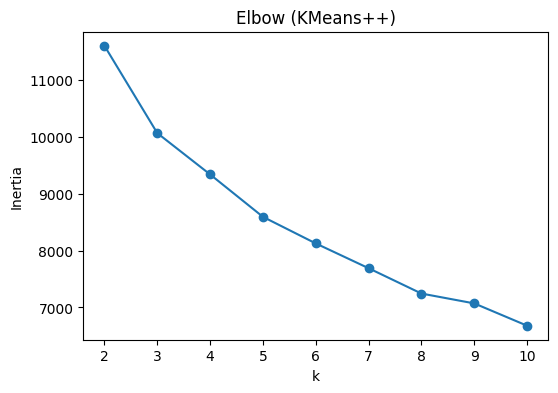

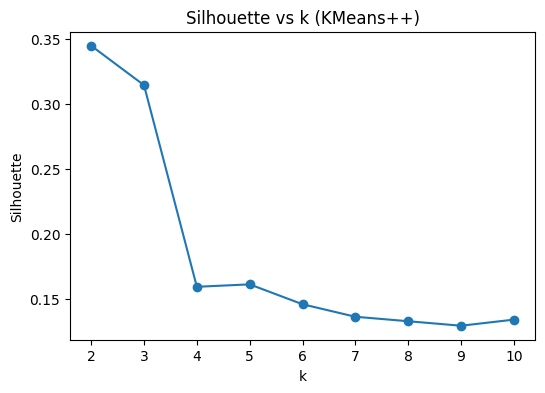

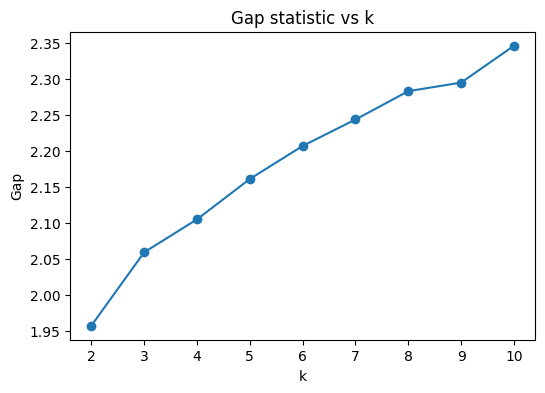

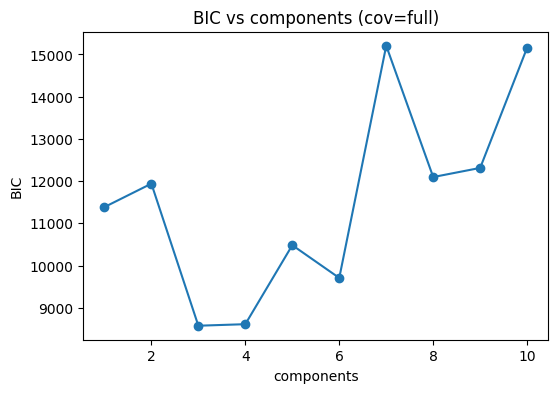

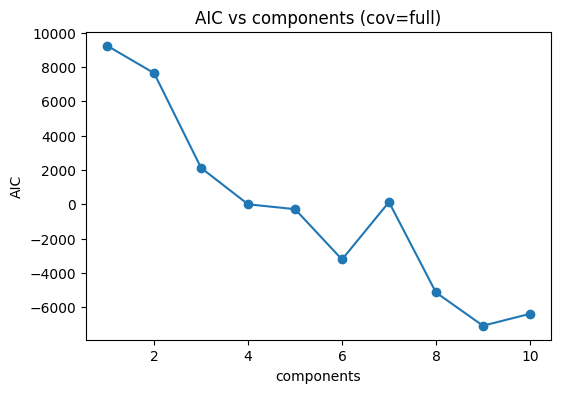

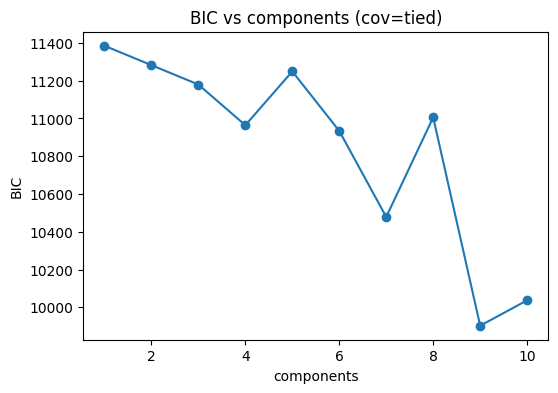

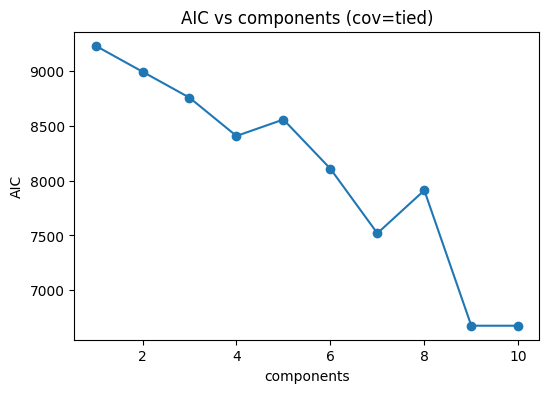

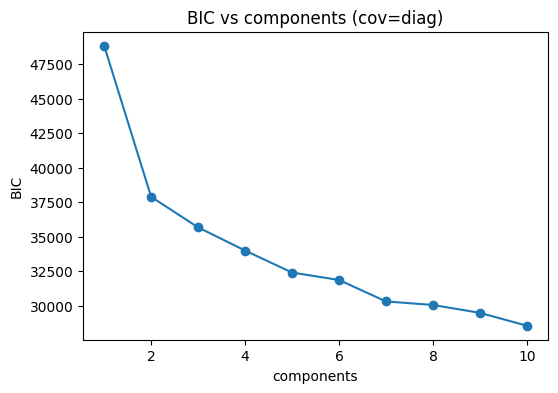

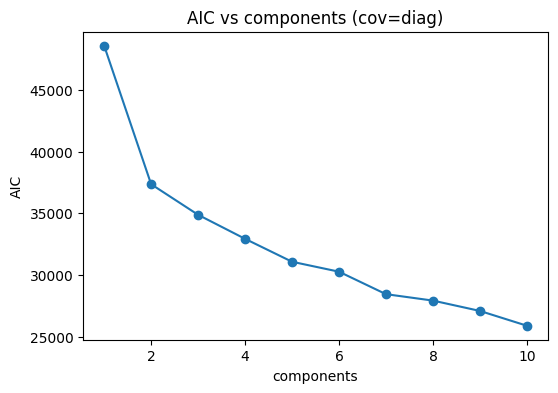

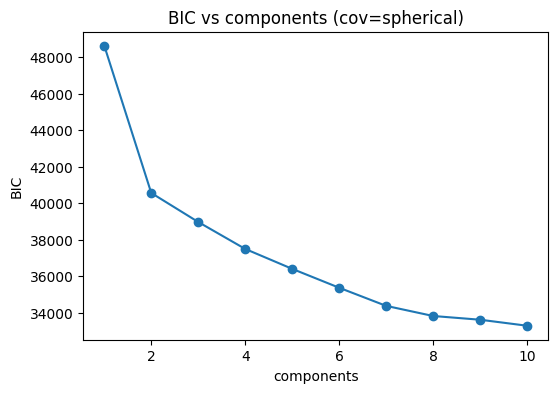

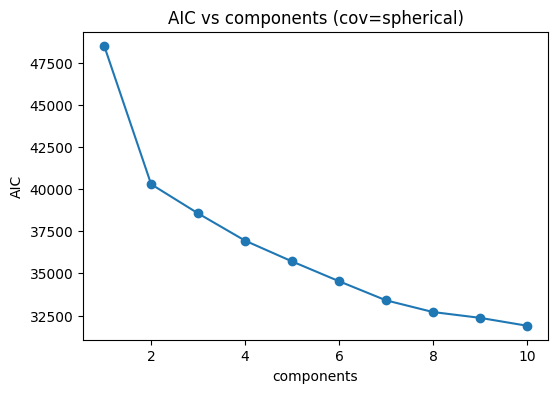

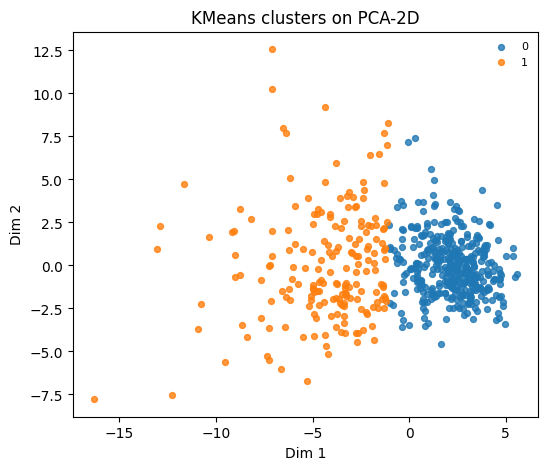

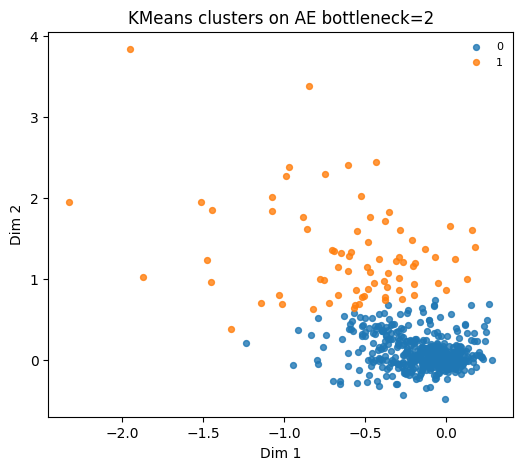

Saved results/all_results.csv with 56 rows


,silhouette,davies_bouldin,calinski_harabasz,wcss,ari,nmi,purity,confusion_matrix,confusion_labels,experiment,...,init,k,time_sec,iters,log_likelihood,bic,aic,cov,dim,rec_mse
0,0.344734,1.309289,267.680436,11595.683313,0.676505,0.562021,0.912127,"[[344, 13], [37, 175]]","[0, 1]",E1,...,kmeans++,2,0.001243,8,NaN,NaN,NaN,NaN,NaN,NaN
1,0.343382,1.320510,267.691716,11595.526607,0.653625,0.532408,0.905097,"[[339, 18], [36, 176]]","[0, 1]",E1,...,random,2,0.000746,6,NaN,NaN,NaN,NaN,NaN,NaN
2,0.147455,1.966664,67.239679,13792.868977,0.321036,0.279951,0.789104,"[[0, 94, 263], [15, 171, 26], [0, 0, 0]]","[0, 1, 2]",E2,...,NaN,3,0.075895,31,428.803587,8575.743032,2116.392827,full,NaN,NaN
3,0.094505,2.005950,32.547104,11652.206140,0.146592,0.182262,0.753954,"[[2, 311, 4, 0, 4, 1, 0, 3, 32], [0, 128, 3, 3...","[0, 1, 2, 3, 4, 5, 6, 7, 8]",E2,...,NaN,9,0.286510,45,-2594.670231,9902.843625,6675.340463,tied,NaN,NaN
4,0.048151,2.172302,75.472364,7706.133782,0.150672,0.338435,0.926186,"[[64, 52, 26, 78, 5, 0, 52, 0, 58, 22], [1, 1,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",E2,...,NaN,10,0.012923,16,-12339.555436,28542.534056,25897.110872,diag,NaN,NaN


In [10]:
import os
os.makedirs("results", exist_ok=True)

set_seed(42)

K_RANGE = list(range(2, 11))
DIM_LIST = [2, 5, 10, 15, 20]

results = []  # list of dict rows

# ---------------- Experiment 1: KMeans on original data ----------------
inert_pp, iters_pp = elbow_inertia(Xs, K_RANGE, init="kmeans++", seed=42)
inert_rn, iters_rn = elbow_inertia(Xs, K_RANGE, init="random", seed=42)
sil_pp = silhouette_over_k(Xs, K_RANGE, init="kmeans++", seed=42)
gaps, sk, wk = gap_statistic(Xs, K_RANGE, B=10, seed=42, init="kmeans++")

best_k_sil = int(K_RANGE[int(np.argmax(sil_pp))])
print("Best k by silhouette (KMeans++):", best_k_sil)

km_pp, t_pp = run_kmeans(Xs, best_k_sil, init="kmeans++", seed=42)
km_rn, t_rn = run_kmeans(Xs, best_k_sil, init="random", seed=42)

m1_pp = compute_all_metrics(Xs, km_pp.labels_, y_true=y, gmm_model=None)
m1_rn = compute_all_metrics(Xs, km_rn.labels_, y_true=y, gmm_model=None)
m1_pp.update({"experiment":"E1", "method":"KMeans", "space":"orig", "init":"kmeans++", "k":best_k_sil, "time_sec":t_pp, "iters":len(km_pp.inertia_history_)})
m1_rn.update({"experiment":"E1", "method":"KMeans", "space":"orig", "init":"random", "k":best_k_sil, "time_sec":t_rn, "iters":len(km_rn.inertia_history_)})
results += [m1_pp, m1_rn]

# Plots
line_curve(K_RANGE, inert_pp, title="Elbow (KMeans++)", xlabel="k", ylabel="Inertia")
plt.show()
line_curve(K_RANGE, sil_pp, title="Silhouette vs k (KMeans++)", xlabel="k", ylabel="Silhouette")
plt.show()
line_curve(K_RANGE, gaps, title="Gap statistic vs k", xlabel="k", ylabel="Gap")
plt.show()

# ---------------- Experiment 2: GMM on original data ----------------
cov_types = ["full","tied","diag","spherical"]
COMP_RANGE = list(range(1, 11))
for cov in cov_types:
    bics, aics = [], []
    for k in COMP_RANGE:
        gmm, t = run_gmm(Xs, k, covariance_type=cov, seed=42)
        bics.append(gmm.bic(Xs))
        aics.append(gmm.aic(Xs))
    line_curve(COMP_RANGE, bics, title=f"BIC vs components (cov={cov})", xlabel="components", ylabel="BIC")
    plt.show()
    line_curve(COMP_RANGE, aics, title=f"AIC vs components (cov={cov})", xlabel="components", ylabel="AIC")
    plt.show()

# pick best by BIC (smallest) for each cov type
for cov in cov_types:
    best_k = None
    best_bic = np.inf
    best_model = None
    best_time = None
    for k in COMP_RANGE:
        gmm, t = run_gmm(Xs, k, covariance_type=cov, seed=42)
        bic = gmm.bic(Xs)
        if bic < best_bic:
            best_bic = bic
            best_k = k
            best_model = gmm
            best_time = t
    labels = best_model.predict(Xs)
    m2 = compute_all_metrics(Xs, labels, y_true=y, gmm_model=best_model)
    m2.update({"experiment":"E2", "method":"GMM", "space":"orig", "cov":cov, "k":best_k, "time_sec":best_time, "iters":len(best_model.log_likelihood_history_)})
    results.append(m2)

# ---------------- Experiment 3: KMeans after PCA ----------------
for d in DIM_LIST:
    pca, Z, rec = pca_embed(Xs, d)
    km, t = run_kmeans(Z, 2, init="kmeans++", seed=42)  # dataset is binary; still do selection if you want
    m = compute_all_metrics(Z, km.labels_, y_true=y, gmm_model=None)
    m.update({"experiment":"E3", "method":"KMeans", "space":"pca", "dim":d, "rec_mse":rec, "k":2, "time_sec":t, "iters":len(km.inertia_history_)})
    results.append(m)
    if d == 2:
        scatter_2d(Z, km.labels_, title="KMeans clusters on PCA-2D")
        plt.show()

# ---------------- Experiment 4: GMM after PCA ----------------
for d in DIM_LIST:
    pca, Z, rec = pca_embed(Xs, d)
    for cov in cov_types:
        gmm, t = run_gmm(Z, 2, covariance_type=cov, seed=42)
        labels = gmm.predict(Z)
        m = compute_all_metrics(Z, labels, y_true=y, gmm_model=gmm)
        m.update({"experiment":"E4", "method":"GMM", "space":"pca", "dim":d, "cov":cov, "rec_mse":rec, "k":2, "time_sec":t, "iters":len(gmm.log_likelihood_history_)})
        results.append(m)

# ---------------- Experiment 5: KMeans after Autoencoder ----------------
for d in DIM_LIST:
    ae, Z, rec = ae_embed(Xs, bottleneck_dim=d, epochs=200, batch_size=64, lr=1e-3, lr_decay=0.995, l2=1e-4, seed=42, verbose=0)
    km, t = run_kmeans(Z, 2, init="kmeans++", seed=42)
    m = compute_all_metrics(Z, km.labels_, y_true=y, gmm_model=None)
    m.update({"experiment":"E5", "method":"KMeans", "space":"ae", "dim":d, "rec_mse":rec, "k":2, "time_sec":t, "iters":len(km.inertia_history_)})
    results.append(m)
    if d == 2:
        scatter_2d(Z, km.labels_, title="KMeans clusters on AE bottleneck=2")
        plt.show()

# ---------------- Experiment 6: GMM after Autoencoder ----------------
for d in DIM_LIST:
    ae, Z, rec = ae_embed(Xs, bottleneck_dim=d, epochs=200, batch_size=64, lr=1e-3, lr_decay=0.995, l2=1e-4, seed=42, verbose=0)
    for cov in cov_types:
        gmm, t = run_gmm(Z, 2, covariance_type=cov, seed=42)
        labels = gmm.predict(Z)
        m = compute_all_metrics(Z, labels, y_true=y, gmm_model=gmm)
        m.update({"experiment":"E6", "method":"GMM", "space":"ae", "dim":d, "cov":cov, "rec_mse":rec, "k":2, "time_sec":t, "iters":len(gmm.log_likelihood_history_)})
        results.append(m)

# results table
res_df = pd.DataFrame(results)
res_df.to_csv("results/all_results.csv", index=False)
print("Saved results/all_results.csv with", len(res_df), "rows")
res_df.head()


In [11]:
# Summary table (pick key metrics)
key_cols = ["experiment","method","space","dim","cov","init","k","silhouette","davies_bouldin","calinski_harabasz","ari","nmi","purity","rec_mse","bic","aic","log_likelihood","time_sec","iters"]
for c in key_cols:
    if c not in res_df.columns:
        res_df[c] = np.nan
summary = res_df[key_cols].sort_values(["experiment","method","space","dim","cov","init"], na_position="last")
summary.to_csv("results/summary_table.csv", index=False)
summary.head(20)


,experiment,method,space,dim,cov,init,k,silhouette,davies_bouldin,calinski_harabasz,ari,nmi,purity,rec_mse,bic,aic,log_likelihood,time_sec,iters
0,E1,KMeans,orig,NaN,NaN,kmeans++,2,0.344734,1.309289,267.680436,0.676505,0.562021,0.912127,NaN,NaN,NaN,NaN,0.001243,8
1,E1,KMeans,orig,NaN,NaN,random,2,0.343382,1.320510,267.691716,0.653625,0.532408,0.905097,NaN,NaN,NaN,NaN,0.000746,6
4,E2,GMM,orig,NaN,diag,NaN,10,0.048151,2.172302,75.472364,0.150672,0.338435,0.926186,NaN,28542.534056,25897.110872,-12339.555436,0.012923,16
2,E2,GMM,orig,NaN,full,NaN,3,0.147455,1.966664,67.239679,0.321036,0.279951,0.789104,NaN,8575.743032,2116.392827,428.803587,0.075895,31
5,E2,GMM,orig,NaN,spherical,NaN,10,0.092087,1.902491,83.753499,0.151043,0.330503,0.926186,NaN,33280.372413,31894.674555,-15628.337277,0.008974,14
3,E2,GMM,orig,NaN,tied,NaN,9,0.094505,2.005950,32.547104,0.146592,0.182262,0.753954,NaN,9902.843625,6675.340463,-2594.670231,0.286510,45
6,E3,KMeans,pca,2.0,NaN,NaN,2,0.508469,0.846740,580.876272,0.659231,0.540381,0.906854,0.367568,NaN,NaN,NaN,0.000719,6
7,E3,KMeans,pca,5.0,NaN,NaN,2,0.393223,1.140900,345.069305,0.670721,0.554612,0.910369,0.152657,NaN,NaN,NaN,0.000844,8
8,E3,KMeans,pca,10.0,NaN,NaN,2,0.357745,1.256692,288.091573,0.676505,0.562021,0.912127,0.048431,NaN,NaN,NaN,0.000881,8
9,E3,KMeans,pca,15.0,NaN,NaN,2,0.348078,1.294817,273.070876,0.676505,0.562021,0.912127,0.013512,NaN,NaN,NaN,0.000901,8
